# CS337 - OPERATING SYSTEMS- Project 7 Software Synchronization
#### By: Matthew Bass


### Table of Contents

* [Overview](#over)
* [Setup](#set)
* [Conclusion](#con)



**Project Overview:** <a class="anchor" id="over"></a>

In this project I will, write a small class to implement a `Semaphore` class
using a `counter` and a `condition` variable.  Here’s the documentation for
[condition variables/objects in Python](https://docs.python.org/3/library/threading.html#condition-objects)



### PREREQUISITES:
    Python 3
    Jupyter
    jupyter_contrib_nbextensions
    random
    threading
    datclasses
    autopep8


<br>

-----

### Setup: <a class="anchor" id="set"></a>

To start I am using this code to make all my code blocks hide-able, thanks to
[stackoverflow](https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer).



In [1]:
# %%HTML
# <script>
#     function luc21893_refresh_cell(cell) {
#         if( cell.luc21893 ) return;
#         cell.luc21893 = true;
#         console.debug('New code cell found...' );
#
#         var div = document.createElement('DIV');
#         cell.parentNode.insertBefore( div, cell.nextSibling );
#         div.style.textAlign = 'right';
#         var a = document.createElement('A');
#         div.appendChild(a);
#         a.href='#'
#         a.luc21893 = cell;
#         a.setAttribute( 'onclick', "luc21893_toggle(this); return false;" );
#
#         cell.style.visibility='hidden';
#         cell.style.position='absolute';
#         a.innerHTML = '[show code]';
#
#     }
#     function luc21893_refresh() {
#         if( document.querySelector('.code_cell .input') == null ) {
#             // it apeears that I am in a exported html
#             // hide this code
#             var codeCells = document.querySelectorAll('.jp-InputArea')
#             codeCells[0].style.visibility = 'hidden';
#             codeCells[0].style.position = 'absolute';
#             for( var i = 1; i < codeCells.length; i++ ) {
#                 luc21893_refresh_cell(codeCells[i].parentNode)
#             }
#             window.onload = luc21893_refresh;
#         }
#         else {
#             // it apperas that I am in a jupyter editor
#             var codeCells = document.querySelectorAll('.code_cell .input')
#             for( var i = 0; i < codeCells.length; i++ ) {
#                 luc21893_refresh_cell(codeCells[i])
#             }
#             window.setTimeout( luc21893_refresh, 1000 )
#         }
#     }
#
#     function luc21893_toggle(a) {
#         if( a.luc21893.style.visibility=='hidden' ) {
#             a.luc21893.style.visibility='visible';
#             a.luc21893.style.position='';
#             a.innerHTML = '[hide code]';
#         }
#         else {
#             a.luc21893.style.visibility='hidden';
#             a.luc21893.style.position='absolute';
#             a.innerHTML = '[show code]';
#         }
#     }
#
#     luc21893_refresh()
# </script>

#### Imports:

In [2]:
import threading
import random
import time
import contextlib
import io
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import multiprocessing
import warnings
import re
import sys
import numpy as np
import networkx as nx
from dataclasses import dataclass, field



### Semaphore Class:

The Semaphore class allows for the use of a counter and a condition
    variable. It has a counter that is used to determine if the semaphore is
    available or not, the counter variable is set to the value of the number
    of threads that can access the semaphore and is decremented for every
    thread that access the semaphore and incremented every time a thread
    releases the semaphore. It also has a condition  variable that is used to make
    incrementing and decrementing the counter thread safe (an atomic operation).
    Its attributes are:
- `counter`: An integer that represents the number of threads have currently
    acquired the semaphore.

- `condition`: A condition variable that is used to make
    incrementing and decrementing the counter thread safe (an atomic operation)

In [3]:
@dataclass
class Semaphore():

    counter: int = field(default=1)
    condition: threading.Condition = field(default = threading.Condition(),
                                           init=False)

    def acquire(self):
        '''
        This method acquires the lock for the condition variable before
        decrementing the counter by one, then it checks if the counter is
        below zero and sets the thread to sleep if true.  Otherwise, it
        releases the lock.

        '''

        # acquire the lock for the condition variable with the context manager
        with self.condition:
            # decrement the counter
            self.counter -= 1

            # check if the counter is below zero
            # if so, set the thread to sleep
            # otherwise, release the lock
            if self.counter < 0:
                self.condition.wait()

        return




    def release(self):
        '''
        This method acquires the condition lock and increments the counter by
        one, notifies a single sleeping thread, and releases the lock.
        '''

        # # acquire the lock
        # self.condition.acquire()
        #
        # # increment the counter
        # self.counter += 1
        #
        # # notify a single sleeping thread
        # self.condition.notify()
        #
        # # release the lock
        # self.condition.release()

        # acquire the lock for the condition variable with the context manager
        with self.condition:
            # increment the counter
            self.counter += 1

            # notify a single sleeping thread
            self.condition.notify()

        return

    # Make the Semaphore class a context manager
    __enter__ = acquire
    __exit__ = release


### Buffer Simulation ( Semaphore Test ):

Now to test my `Semaphore` class, I will use the Buffer example from class where
 we used Python semaphores and replace the Python semaphores with my own
 `Semaphore` class. The output should be similar to the python semaphore
 solution, in the sense that:

1. We see no errors, especially pop with empty list error.

2. The buffer never exceeds 10.

3. Every item added to the buffer is removed at the end of each run.


This buffer simulation is a producer and consumer problem.  The producers
will put items into the `buffer`, and the consumers will take items out of the
`buffer`.  The buffer is bounded by a maximum size of 10.  The items will be
unique numbers 1 - `buffer_size`.

There will be 3 `Semaphores` used in this simulation.  The first is
`access` which is used to synchronize access to the `buffer` between the
consumer and producer threads, it starts with a value of 1 for the counter
and is decremented by 1 for each thread that wants to access the buffer,
since only one thread can access the buffer at a time. The
second is `empty` which is used to signal the number of empty spaces in the
`buffer` it starts with a value the size of `buffer_size` and is decremented
by 1 for each thread that adds an item to the `buffer`. The third is `full`
which is used to signal if the `buffer` is full or not and starts
at 0 and is incremented by 1 every time the `buffer` is full.

Before I make the `bufferSimulation()` function, I will define the `Producer` and
`Consumer` threads.

#### Producer Thread:

The `Producer` thead will put unique numbers into the buffer. It inherits from
 the threading.Thread class.


The attributes of the `Producer` class are:
- `producer_id`: An integer that represents the id of the producer.

- `num_produce`: An integer that represents the number of items to produce.

- `buffer`: A list that represents the buffer (shared resource).

- `access`: A `Semaphore` object that represents the number of threads that can
    access the buffer at a time (starts at 1 to represent only one thread can
    access the buffer at a time).

- `empty`: A `Semaphore` object that represents the number of empty spaces in the
    buffer.

- `full`: A `Semaphore` object that represents if the buffer is full or not
(starts at 0 to represent not full and is incremented by 1 every time the buffer
is full).

- `sleep_amt`: An integer that represents the amount of time the thread will
    sleep for after producing an item.

- `debug`: A boolean that represents if the thread should print debug messages
    or not.


This class will produce numbers `(producer_id * num_produce) -
 num_produce + (producer_id * num_produce)` and put them into the buffer
 `num_produce` times.  It will sleep for `sleep_amt` seconds after each item is
 produced.


Here is the code for the `Producer` class:

In [4]:
class Producer(threading.Thread):
    def __init__(self,
                 producer_id: int ,
                 num_produce: int,
                 buffer: list,
                 access: Semaphore,
                 empty: Semaphore,
                 full: Semaphore,
                 sleep_amt: float = 1,
                 debug: bool = False):
        '''
        The constructor for the Producer class.

        Args:
            producer_id: An integer that represents the producer number.
            num_produce: An integer that represents the number of items that
                each producer will put into the buffer.
            buffer: A list that represents the buffer.
            access: A Semaphore that represents the access lock for the buffer.
            empty: A Semaphore that represents the empty lock for the buffer.
            full: A `Semaphore` object that represents if the buffer is full or not
                (starts at 0 to represent not full and is incremented by 1
                every time the buffer is full).
            sleep_amt: A float that represents the amount of time the thread
            debug: A boolean that represents whether or not the debug mode is
        '''
        threading.Thread.__init__(self)
        self.producer_id = producer_id
        self.num_produce = num_produce
        self.buffer = buffer
        self.access = access
        self.empty = empty
        self.full = full
        self.sleep_amt = sleep_amt
        self.debug = debug
        return

    def run(self):
        '''
        The run method for the Producer class.  This method will produce
        numbers 0 + (producer_num * NUM_PRODUCE) - NUM_PRODUCE + (producer_num *
        NUM_PRODUCE) and put them into the buffer.
        '''
        # Make a unique data array
        data_array = np.arange(self.num_produce) + \
                     (self.producer_id * self.num_produce)

        for data in data_array:

            # Acquire the empty semaphore
            self.empty.acquire()

            # Acquire the access semaphore
            self.access.acquire()

            # Add the data to the buffer
            self.buffer.append(data)

            if self.debug:
                print(f"\nProducer {self.producer_id} " +\
                      f"({threading.current_thread().name}) " +\
                      f"added {data} to the buffer. " +\
                      f"Buffer Size: {len(self.buffer)}")


            # Release the access semaphore
            self.access.release()

            # Release the full semaphore
            self.full.release()

            # Sleep for the amount of time specified
            if self.sleep_amt != -1:
                time.sleep(self.sleep_amt)
            else:
                time.sleep((random.random() * 5) + 0.1)

        return

#### Consumer Thread:

The `Consumer` thead will take unique numbers from the buffer. It inherits from
 the threading.Thread class.





The attributes of the `Consumer` class are:
- `consumer_id`: An integer that represents the id of the consumer.

- `num_consume`: An integer that represents the number of items to consume.

- `buffer`: A list that represents the buffer (shared resource).

- `access`: A `Semaphore` object that represents the number of threads that can
    access the buffer at a time (starts at 1 to represent only one thread can
    access the buffer at a time).

- `empty`: A `Semaphore` object that represents the number of empty spaces in the
    buffer.

- `full`: A `Semaphore` object that represents tif the buffer is full or not
(starts at 0 to represent not full and is incremented by 1 every time the buffer
is full).

- `sleep_amt`: An integer that represents the amount of time the thread will
    sleep for after producing an item. if sleep is -1, the thread will sleep for
    a random amount of time.

- `debug`: A boolean that represents if the thread should print debug messages
    or not.


 This is a `Consumer` class that inherits from the threading.Thread class.
    This class will consume `num_produce * (consumer_amt/producer_amt) =
    num_consumed` numbers from the buffer and print them out.


Here is the code for the `Consumer` class:

In [5]:
class Consumer(threading.Thread):

    def __init__(self,
                 consumer_id: int,
                 num_consume: int,
                 buffer: list,
                 access: Semaphore,
                 empty: Semaphore,
                 full: Semaphore,
                 sleep_amt: float = 1,
                 debug: bool = False):
        '''
        The constructor for the Consumer class.

        Args:
            consumer_id: An integer that represents the consumer number.
            num_consume: An integer that represents the number of items that
                each consumer will consume from the buffer.
            buffer: A list that represents the buffer.
            access: A `Semaphore` object that represents the number of
                    threads that can access the buffer at a time (starts at 1
                     to represent only one thread can access the buffer at a
                     time).

            empty: A Semaphore that represents the empty lock for the buffer.
            full: A `Semaphore` object that represents tif the buffer is full or not
                    (starts at 0 to represent not full and is incremented by
                    1 every time the buffer is full).
            sleep_amt: A float that represents the amount of time that the
                consumer will sleep for.
            debug: A boolean that represents whether or not the debug mode is
        '''
        threading.Thread.__init__(self)
        self.consumer_id = consumer_id
        self.num_consume = num_consume
        self.buffer = buffer
        self.access = access
        self.empty = empty
        self.full = full
        self.sleep_amt = sleep_amt
        self.debug = debug
        return

    def run(self):
        '''
        The run method for the Consumer class.  This method will consume
        numbers from the buffer and print them out.
        '''
        for _ in range(self.num_consume):

            # Acquire the full semaphore
            self.full.acquire()

            # Acquire the access semaphore
            self.access.acquire()

            # Remove the data from the buffer
            data = self.buffer.pop(0)

            if self.debug:
                print(f"Consumer {self.consumer_id} " +\
                      f"({threading.current_thread().name}) " +\
                      f"popped {data} from the buffer. " +\
                      f"Buffer Size: {len(self.buffer)}")

            # Release the access semaphore
            self.access.release()

            # Release the empty semaphore
            self.empty.release()

            # Sleep for set sleep amount
            if self.sleep_amt != -1:
                time.sleep(self.sleep_amt)
            else:
                time.sleep((random.random() * 5) + 0.1)


        return


#### Buffer Simulation Function:

 The `bufferSimulation()` function will run the `Producer` and `Consumer`
 threads and the buffer simulation to test the `Semaphore` class.

The `bufferSimulation()` function will take in the following arguments:
- `consumer_amt` (int): The number of `Consumer`s to create.

- `producer_amt` (int): The number of `Producer`s to create.

- `consumer_sleep` (float): The amount of time that each `Consumer` will
sleep. (-1 to represent random amount of time)

- `producer_sleep` (float): The amount of time that each `Producer` will
sleep. (-1 to represent random amount of time)

- `data_amt` (int): The number of items that each `Producer` will produce.

- `buffer_size` (int): The size of the `buffer`.

- `debug` (bool): If true, will print debug statements.




In [6]:
def bufferSimulation(consumer_amt: int = 1, producer_amt: int = 1,
                     consumer_sleep: float = -1, producer_sleep: float = -1,
                     data_amt : int = 20, buffer_size = 10,
                     debug: bool = True):
    '''
    This function will simulate a buffer with a producer and consumers.
    Args:
        consumer_amt (int): The number of consumers to create.
        producer_amt (int): The number of producers to create.
        consumer_sleep (float): The amount of time that each consumer will sleep.
        producer_sleep (float): The amount of time that each producer will sleep.
        data_amt (int): The number of items that each producer will produce.
        buffer_size (int): The size of the buffer.
        debug (bool): If true, will print debug statements.

    Returns:

    '''

    # Make the variables that will be shared among the threads

    buffer = []


    # Semaphores
    access = Semaphore(counter=1)
    empty = Semaphore(counter=buffer_size)
    full = Semaphore(counter=0)

    # Calculate the consumer amount
    num_consume = data_amt // consumer_amt

    # Create the consumers
    consumers = []
    for i in range(consumer_amt):
        consumers.append(Consumer(i, num_consume, buffer, access, empty, full,
                                  consumer_sleep, debug))

    # Create the producers
    producers = []
    for i in range(producer_amt):
        producers.append(Producer(i, data_amt, buffer, access, empty, full,
                                  producer_sleep, debug))


    # Start the producer and consumer threads
    for producer in producers:
        producer.start()
    for consumer in consumers:
        consumer.start()

    # Wait for the producer and consumer threads to finish
    for producer in producers:
        producer.join()
    for consumer in consumers:
        consumer.join()


    if len(buffer) == 0:
        print('\nThe buffer is empty after all the producers and consumers '
              'have finished')
    else:
        print('\nThe buffer is not empty after all the producers and consumers '
              'have finished')

    print(f'\nDone with the buffer simulation !!!')
    return

#### Running Buffer Simulation:

Now I will run the buffer simulation to see if it passes the tests, to see if
   1. We see no errors, especially pop with empty list error.
   2. The buffer never exceeds `buffer_size` (in these sims 10).
   3. Every item added to the buffer is removed at the end of each run.


To ensure that every item added to the buffer is removed at the end of each
   run, I will run the simulation multiple times I have added the lines of
   code below to the `bufferSimulation()` function to check that the buffer
   is empty once both the producer and consumer threads have finished.(`join
   ()`):
   ```python
   if len(buffer) == 0:
       print('The buffer is empty after all the producers and consumers have '
              'finished')
   else:
       print('The buffer is not empty after all the producers and consumers '
              'have finished')
   ```


##### First Buffer Simulation ( Tests 1 and 3 ):

Then to test that there are no errors when popping from the empty buffer, I
made it so that the `Producer` will sleep for 2 seconds and `Consumer` will
sleep for 1 second. This means that the `Consumer` should be able to consume
more items than the `Producer` can produce, we will see that the `buffer` never
exceeds a size of 1 because the consumer will always be taking the item in
the buffer before the producer can add another item to the buffer. If the
simulation runs with no errors and the `buffer` never exceeds a size of 1,
then the simulation passes test 1 and 3 in this simulation.

In [7]:

bufferSimulation(consumer_amt=1, producer_amt=1, consumer_sleep=1,
                     producer_sleep=3, data_amt=5, buffer_size=10, debug=True)


Producer 0 (Thread-9) added 0 to the buffer. Buffer Size: 1
Consumer 0 (Thread-8) popped 0 from the buffer. Buffer Size: 0

Producer 0 (Thread-9) added 1 to the buffer. Buffer Size: 1
Consumer 0 (Thread-8) popped 1 from the buffer. Buffer Size: 0

Producer 0 (Thread-9) added 2 to the buffer. Buffer Size: 1
Consumer 0 (Thread-8) popped 2 from the buffer. Buffer Size: 0

Producer 0 (Thread-9) added 3 to the buffer. Buffer Size: 1
Consumer 0 (Thread-8) popped 3 from the buffer. Buffer Size: 0

Producer 0 (Thread-9) added 4 to the buffer. Buffer Size: 1
Consumer 0 (Thread-8) popped 4 from the buffer. Buffer Size: 0

The buffer is empty after all the producers and consumers have finished

Done with the buffer simulation !!!


From this first simulation, we see that the buffer never exceeds a size of 1
and there are no errors when popping from the empty buffer, and the `buffer`
is empty after  the producer and consumer have finished.This means
that the simulation passes tests 1 and 3.

##### Second Buffer Simulation ( Tests 2 and 3 ):

Then to test that the buffer never exceeds the buffer size, I made it so that
the `Producer` will sleep for 0.5 seconds and `Consumer` will sleep for 3
seconds.
This means that the `Producer` will be able to produce more items than the
`Consumer` can consume, we will see that the `buffer` never exceeds a size of
10 because the `Producer` will always be adding items to the buffer before the
`Consumer` can remove items from the `buffer`. If the simulation runs with no
errors and the `buffer` never exceeds a size of 10 which is the set
`buffer_size`, then the
simulation passes.

I will run the simulation with 15 items (`data_amt = 15`) so that the `buffer`
will get full and the `Producer` will have to wait for the `Consumer` to remove
an item from the `buffer` to make room for the next item.

In [8]:

bufferSimulation(consumer_amt=1, producer_amt=1, consumer_sleep=3,
                     producer_sleep=0.5, data_amt=15, buffer_size=10,
                 debug=True)



Producer 0 (Thread-11) added 0 to the buffer. Buffer Size: 1
Consumer 0 (Thread-10) popped 0 from the buffer. Buffer Size: 0

Producer 0 (Thread-11) added 1 to the buffer. Buffer Size: 1

Producer 0 (Thread-11) added 2 to the buffer. Buffer Size: 2

Producer 0 (Thread-11) added 3 to the buffer. Buffer Size: 3

Producer 0 (Thread-11) added 4 to the buffer. Buffer Size: 4

Producer 0 (Thread-11) added 5 to the buffer. Buffer Size: 5
Consumer 0 (Thread-10) popped 1 from the buffer. Buffer Size: 4

Producer 0 (Thread-11) added 6 to the buffer. Buffer Size: 5

Producer 0 (Thread-11) added 7 to the buffer. Buffer Size: 6

Producer 0 (Thread-11) added 8 to the buffer. Buffer Size: 7

Producer 0 (Thread-11) added 9 to the buffer. Buffer Size: 8

Producer 0 (Thread-11) added 10 to the buffer. Buffer Size: 9

Producer 0 (Thread-11) added 11 to the buffer. Buffer Size: 10
Consumer 0 (Thread-10) popped 2 from the buffer. Buffer Size: 9

Producer 0 (Thread-11) added 12 to the buffer. Buffer Size: 

From this first simulation, we see that the buffer never exceeds a size of 10 `buffer_size`
 and the `buffer` is empty after  the producer and consumer have finished.
 This means that the simulation passes tests 1 and 3. We can see that initially
  the `Producer` was adding items to the buffer at a very high rate, before the
  `Consumer` was able to consume them. Then once the `buffer` was fullm with a
   size of 10, the `Producer` had to wait for the `Consumer` to remove an item
   from the `buffer`
   to make room for the next item, before the `Producer` was able to add
   another item to the `buffer`.

##### Third Buffer Simulation ( All Tests ):

Now to test all 3 tests, I made it so that the `Producer` and `Consumer` will
sleep for a random amount of time between 0.1 and 5.1 seconds and have to
process
 15 numbers of data with a `buffer_size` of 2. This means there is an
 increased chance for both an
 "overflow" and "underflow" of the buffer to occur.

In [9]:
bufferSimulation(consumer_amt=1, producer_amt=1, consumer_sleep=-1,
                     producer_sleep=-1, data_amt=15, buffer_size=2,
                 debug=True)



Producer 0 (Thread-13) added 0 to the buffer. Buffer Size: 1
Consumer 0 (Thread-12) popped 0 from the buffer. Buffer Size: 0

Producer 0 (Thread-13) added 1 to the buffer. Buffer Size: 1
Consumer 0 (Thread-12) popped 1 from the buffer. Buffer Size: 0

Producer 0 (Thread-13) added 2 to the buffer. Buffer Size: 1
Consumer 0 (Thread-12) popped 2 from the buffer. Buffer Size: 0

Producer 0 (Thread-13) added 3 to the buffer. Buffer Size: 1
Consumer 0 (Thread-12) popped 3 from the buffer. Buffer Size: 0

Producer 0 (Thread-13) added 4 to the buffer. Buffer Size: 1
Consumer 0 (Thread-12) popped 4 from the buffer. Buffer Size: 0

Producer 0 (Thread-13) added 5 to the buffer. Buffer Size: 1
Consumer 0 (Thread-12) popped 5 from the buffer. Buffer Size: 0

Producer 0 (Thread-13) added 6 to the buffer. Buffer Size: 1
Consumer 0 (Thread-12) popped 6 from the buffer. Buffer Size: 0

Producer 0 (Thread-13) added 7 to the buffer. Buffer Size: 1
Consumer 0 (Thread-12) popped 7 from the buffer. Buffer 

From this third and final simulation, we see that the `buffer` never exceeds
its `buffer_size` of 2 , there are no errors when popping from the empty, and
the `buffer` is empty after the `Producer` and `Consumer` have finished.
Therefore, the buffer simulation passes all 3 tests.

<br>

### Dining Philosophers Problem:

Now I will demonstrate a deadlock with a basic simulation of the dining
philosophers problem. The dining philosophers problem is an example problem
often used in concurrent algorithm design to illustrate synchronization
issues and techniques for resolving them.

It states that `philosopher_amt` `Philosopher`s seated around a circular table
with one `Fork` between each pair of `Philosophers`. There is one `Fork`
between each
`Philosopher`. A `Philosopher` may eat if he can pick up the two `Forks`
adjacent to him. One `Fork` may be picked up by any one of its adjacent
`Philosophers` but not both.

For this simulation I created custom classed to represent the philosophers
and forks. Below are the 2 base classes (threads) :

1. `Philosopher`
2. `Fork`


#### Fork Semaphore:

 A Fork class that inherits from the Semaphore class.  This class is used
    to represent a fork in the dining philosophers problem.  It has a counter
    that is used to determine if the fork is available or not, the counter
    variable is set to 1 as stated before. When a `Philosopher` uses the fork
     it is decremented to 0 then when the fork is release it is incremented
     back to 1. It also has a condition variable that is used to make
    incrementing and decrementing the counter thread safe (an atomic operation).
    Its attributes are:
- `counter`: An integer that represents the number of threads that have
    acquired the fork. (here set to 1)
- `condition`: A condition variable that is used to make incrementing and
    decrementing the counter thread safe (an atomic operation).

- `fork_id`: An integer that represents the id of the fork.


Here is the code for the `Fork` class:

In [10]:
class Fork(Semaphore):
    '''
    A Fork class that inherits from the Semaphore class.  This class is used
    to represent a fork in the dining philosophers problem.  It has a counter
    that is used to determine if the fork is available or not.  It also has a
    condition variable that is used to make incrementing and decrementing the
    counter thread safe (an atomic operation).

    Attributes:
        counter: An integer that represents the number of threads that are
            currently waiting on the condition variable.
        condition: A condition variable that is used to signal threads that
            the counter is 0.
        fork_id: An integer that represents the id of the fork.
    '''

    def __init__(self, fork_id):
        '''
        This method initializes the fork with the fork_id.
        '''

        # Initialize the super with a counter of 1
        # to show that only 1 thread can use the fork at a time
        super().__init__(1)

        # initialize the fork with the fork_id
        self.fork_id = fork_id
        return


#### Philosopher Thread:

The `Philosopher` class that is
 a child of the `Thread` class and acts as a parent class to all other
 philosopher threads, that have synchronization (deadlock prevention)
 solutions implemented. The attributes of the base `Philosopher` class are:

- `name`: A string that represents the name of the philosopher.

- `philosopher_id`: An integer that represents the id of the philosopher.

- `left_fork`: A `Fork` object that represents the left fork of the philosopher.

- `right_fork`: A `Fork` object that represents the right fork of the philosopher.

- `fork_pause_time`: An integer that represents the amount of time the
`Philosopher` will wait pause before eating.

- `time_to_eat`: An integer that represents the amount of times the
philosopher needs to eat.


There are also a few methods that are used to help the philosopher run (eat):
1. `think()`: simulates thinking by sleeping for a random amount of
time, between 0.2 and 0.6 seconds.
2. `eat()`: simulates eating by sleeping for a random amount of time, between
 0.2 and 0.6 seconds.
3. `take_left_fork()`: takes the left fork of the philosopher, does this by aquiring
    the left fork then sleeping for `fork_pause_time` seconds.
4. `take_right_fork()`: takes the right fork of the philosopher, same way as `take_left_fork()`
    but with the right fork.
5. `put_left_fork()`: puts the left fork of the philosopher, does this by releasing
    the left fork.
6. `put_right_fork()`: puts the right fork of the philosopher, same way as `put_left_fork()`
    but with the right fork.


Then there is the main `run()` method that is used to run the philosopher.
In the base `Philosopher` class, I have a `run` method
that makes it so that with a long enough `fork_pause_time` and amount of philosophers
 a deadlock will occur. The `run` method in the `Philosopher` class will run
 until the global class variable `is_running` is set to False, the local instance variable
`philosopher_running` is set to False, or the philosopher has eaten `times_to_eat`
times.

The base run method is structured as follows:
1. `think()` for 0.2 to 0.6 seconds
2. `take_left_fork()`
3. `take_right_fork()`
4. `eat()` for 0.2 to 0.6 seconds
5. `put_right_fork()`
6. `put_left_fork()`
7. increment `times_eaten` by 1
8. print out the name of the `Philosopher` and the number of times they have
eaten

In [11]:
class Philosopher(threading.Thread):

    # a class attribute to signal that the philosophers are running
    is_running = True

    def __init__(self, philosopher_id: int, left_fork: Fork, right_fork: Fork,
                 fork_pause_time: float = 0.5, times_to_eat: int = 2):
        super().__init__(name=f"Philosopher {philosopher_id}")
        self.philosopher_id = philosopher_id
        self.left_fork = left_fork
        self.right_fork = right_fork
        self.fork_pause_time = fork_pause_time
        self.times_to_eat = times_to_eat
        self.times_eaten = 0


        # A bool to be used to toggle the philosopher running per instance
        self.philosopher_running = True

    def think(self):
        print(f"\t\t{self.name} is thinking...")
        time.sleep(random.uniform(0.2, 0.6))
        return

    def eat(self):
        print(f"\t\t{self.name} is eating...")
        time.sleep(random.uniform(0.2, 0.6))
        return

    def take_left_fork(self):
        print(f"\t\t{self.name} is taking left fork  {self.left_fork.fork_id} ...")
        self.left_fork.acquire()
        print(f"\t\t{self.name} is using left fork {self.left_fork.fork_id} ...")

        # Pause for fork_pause_time seconds
        time.sleep(self.fork_pause_time)

        return

    def take_right_fork(self):
        print(f"\t\t{self.name} is taking right fork {self.right_fork.fork_id} ...")
        self.right_fork.acquire()
        print(f"\t\t{self.name} is using right fork {self.right_fork.fork_id} ...")

        # Pause for fork_pause_time seconds
        time.sleep(self.fork_pause_time)

        return

    def put_left_fork(self):
        print(f"\t\t{self.name} is putting left fork {self.left_fork.fork_id} down ...")
        self.left_fork.release()
        print(f"\t\t{self.name} is done with left fork {self.left_fork.fork_id} ...")

        return

    def put_right_fork(self):
        print(f"\t\t{self.name} is putting right fork {self.right_fork.fork_id} down ...")
        self.right_fork.release()
        print(f"\t\t{self.name} is done with right fork {self.right_fork.fork_id} ...")

        return

    def run(self):
        while self.is_running and self.philosopher_running and self.times_eaten < self.times_to_eat:
            self.think()
            self.take_left_fork()
            self.take_right_fork()
            self.eat()
            self.put_right_fork()
            self.put_left_fork()

            self.times_eaten += 1

            print(f"\t{self.name} is done eatting and thinking, it has eaten "
                  f"{self.times_eaten} times")
        return



#### PhilosopherAsym class (Solution 1) :

This is the `PhilosopherAsym` class which is a child of the `Philosopher`
class. The only difference between these two classes is that the
`PhilosopherAsym` class has an asymmetric solution for preventing a deadlock
based on changing how the `run()` method works. In the `PhilosopherAsym`
class's `run()` method, the `take_left_fork()` and `take_right_fork()`
methods are called in the opposite order of one another depending on the
whether the `PhilosopherAsym` has an even or odd `philosopher_id`, odd
`PhilosopherAsym` pick up the `left_fork` then the `right_fork`, and even
`PhilosopherAsym` pick up the `right_fork` then the `left_fork`.

The code for the class is below:

In [12]:
class PhilosopherAsym(Philosopher):

    def __init__(self, philosopher_id: int, left_fork: Fork, right_fork: Fork,
                 fork_pause_time: float = 0.5):

        super().__init__(philosopher_id, left_fork, right_fork, fork_pause_time)
        return

    # Override the run method
    def run(self):

        while self.is_running and self.philosopher_running and self.times_eaten < self.times_to_eat:

            self.think()

            if self.philosopher_id % 2 == 0:
                self.take_left_fork()
                self.take_right_fork()
                self.eat()
                self.put_right_fork()
                self.put_left_fork()
            else:
                self.take_right_fork()
                self.take_left_fork()
                self.eat()
                self.put_left_fork()
                self.put_right_fork()

            self.times_eaten += 1

            print(f"\t{self.name} is done eatting and thinking, it has eaten "
                  f"{self.times_eaten} times")
        return

#### PhilosopherEatCS class (Solution 2) :

This is the `PhilosopherEatCS` class which is a child of the `Philosopher`
class. This is another more complex solution to the problem of deadlock.
The `PhilosopherEatCS` class has the same attributes as the `Philosopher`
class, but it also has the attributes:
- `left_eating`: a mutex lock (`threading.Lock`) that signals when the `PhilosopherEatCS`
  to the left is eating.
- `right_eating`: a mutex lock (`threading.Lock`) that signals when the `PhilosopherEatCS`
  to the right is eating.

These attributes allow a more complex solution to the problem of deadlock,
where the `PhilosopherEatCS` waits for both `Forks` to be available before
it attempts to pick them up (acquire them). This is done in a critical section. It allows philosopher to pick up forks if
both are available. Here the `left_eating` and `right_eating` locks are used
to signal when the `PhilosopherEatCS` to the left and right are done eating,
meaning that both `Forks` are available. (They act as a lock to the crtical
section of acquiring the forks.)

The code for the class is below:

In [13]:
class PhilosopherEatCS(Philosopher):

    def __init__(self, philosopher_id: int, left_fork: Fork, right_fork: Fork,
                 left_eating: threading.Condition,
                 right_eating: threading.Condition,
                 fork_pause_time: float = 0.5):
        '''
        This method initializes a PhilosopherAsym object.

        Parameters:
            philosopher_id: An integer that represents the philosopher's id.
            left_fork: The left fork of the philosopher.
            right_fork: The right fork of the philosopher.
            left_eating: The semaphore that represents if left neighbor is eating.
            right_eating: The semaphore that represents if right neighbor is eating.
            fork_pause_time: The time that the philosopher will pause between
        '''
        super().__init__(philosopher_id, left_fork, right_fork, fork_pause_time)
        self.left_eating = left_eating
        self.right_eating = right_eating
        return

    # Override the run method
    def run(self):
        while self.is_running and \
                self.philosopher_running and\
                self.times_eaten < self.times_to_eat:
            self.think()

            with self.left_eating:
                with self.right_eating:
                    self.take_left_fork()
                    self.take_right_fork()
                    self.eat()
                    self.put_right_fork()
                    self.put_left_fork()


            self.times_eaten += 1

            print(f"\t{self.name} is done eatting and thinking, it has eaten "
                  f"{self.times_eaten} times")



        return




#### Base Dining Philosophers Simulation :

`diningPhilosophers()` is a function to run the dining philosophers problem
(simulation) and output what it is doing. Its arguments are:

- `philosopher_amount`: the amount of `Philosopher` instances at the table

- `simulation_time`: the  maximum amount of time to run the simulation for if
    the philosophers are not done eating this will end the `Philosopher`
    instances allowing the simulation to end.

- `fork_pause_time`: An integer that represents the amount of time the
`Philosopher` will wait pause before eating.

- `times_to_eat`: An integer that represents the amount of times the
`Philosopher` will eat for before it stops running.

- `sim_type`: a string that represents the type of simulation to run.
    - `"deadlock"`: the simulation will run with the `Philosopher()` class that
     has no solution for preventing deadlock.
    - `"asymetric"`: the simulation will run with the `PhilosopherAsym()` class.
    - `"complex"`: the simulation will run with the `PhilosopherEatCS()` class
     that has a complex solution for preventing deadlock. This solution will be
     discussed in more detail later.


In running the dining philosophers simulation, the action of each philosopher
 is outputted to the console, as well as the state of the simulation
 (starting / stopping). Also, once the dining philosophers simulation is done,
  it checks to see if the simulation stopped because the philosophers are
  done eating. If so, it is likely that a deadlock occurred, however this is
  not always the case, the philosophers might just not have been done eating.
  We can be certain a deadlock occurred if the sim stops running before it
  is stated the simulation is stopping.


Below is the code for the `diningPhilosophers()` function:

In [14]:
def diningPhilosophers(philosopher_amt: int = 5, simulation_time: int = 20,
                        fork_pause_time: float = 0.5,
                        times_to_eat: int = 3, sim_type: str = "deadlock"):

    # Get correct philosopher object
    if sim_type == 'deadlock':
        philosopher_obj = Philosopher
    elif sim_type == 'asymetric':
        philosopher_obj = PhilosopherAsym
    elif sim_type == 'complex':
        philosopher_obj = PhilosopherEatCS

    # create the forks
    left_forks = [Fork(i) for i in range(philosopher_amt)]
    right_forks = [left_forks[(i + 1) % philosopher_amt] for i in
                   range(philosopher_amt)]

    # Create a list of philosophers
    if sim_type != 'complex':

        philosophers = [
            philosopher_obj(i, left_forks[i], right_forks[i], fork_pause_time)
            for i in range(philosopher_amt)]

    # If sim
    else:
        # Make eating locks
        left_eating = [threading.Condition() for _ in range(philosopher_amt)]
        right_eating = [left_eating[(i + 1) % philosopher_amt] for i in
                         range(philosopher_amt)]

        # Create philosophers
        philosophers = [philosopher_obj(i,
                                        left_forks[i],
                                        right_forks[i],
                                        left_eating[i],
                                        right_eating[i],
                                        fork_pause_time) for i in
                        range(philosopher_amt)]

    print("\nStarting the Dining Philosophers Simulation...")

    # Start the philosophers
    for philosopher in philosophers:
        philosopher.start()

    # Wait for the simulation_time
    time.sleep(simulation_time)
    philosopher_obj.is_running = False
    print("\nEnding the Dining Philosophers Simulation...")

    # time.sleep(philosopher_amt*2.5)

    if sim_type != 'deadlock':
        for philosopher in philosophers:
            philosopher.join()


    print("The Dining Philosophers Simulation has ended.")


    # See if all philosophers have eaten the correct number of times
    all_eaten = True
    for philosopher in philosophers:
        if philosopher.times_eaten != philosopher.times_to_eat:
            print(f"\n{philosopher.name} has eaten {philosopher.times_eaten} times instead of {philosopher.times_to_eat} times.")
            all_eaten = False


    if all_eaten:
        print("\nAll philosophers have eaten the correct number of times.")


    return

#### Running the Dining Philosophers Simulations

Now I will run the `diningPhilosophers()` function to run the dining philosophers
 simulation multiple times to show a deadlock happening and then the 2 different
  solutions for preventing deadlock.


##### Deadlock Simulation :

In [15]:
# diningPhilosophers(philosopher_amt=5, simulation_time=20, fork_pause_time=0.5,
#                    times_to_eat=3, sim_type='deadlock')

Here when running the simulation with the `Philosopher` class, a deadlock
clearly occurs because the philosophers stop outputting what they are doing to the
 console long before the simulation shuts down. This indicates that they have
  stopped running it general because they print out something each step they
  run. A deadlock happening is further backed by the fact that the
  philosophers have not eaten at all (or once, 2 times in extreme cases).


##### Solution 1 Simulation (Asymmetric) :

In [16]:
diningPhilosophers(philosopher_amt=5, simulation_time=20, fork_pause_time=0.5,
                   times_to_eat=3, sim_type='asymetric')


Starting the Dining Philosophers Simulation...
		Philosopher 0 is thinking...
		Philosopher 1 is thinking...
		Philosopher 2 is thinking...
		Philosopher 3 is thinking...
		Philosopher 4 is thinking...
		Philosopher 3 is taking right fork 4 ...
		Philosopher 3 is using right fork 4 ...
		Philosopher 1 is taking right fork 2 ...
		Philosopher 1 is using right fork 2 ...
		Philosopher 0 is taking left fork  0 ...
		Philosopher 0 is using left fork 0 ...
		Philosopher 2 is taking left fork  2 ...
		Philosopher 4 is taking left fork  4 ...
		Philosopher 3 is taking left fork  3 ...
		Philosopher 3 is using left fork 3 ...
		Philosopher 1 is taking left fork  1 ...
		Philosopher 1 is using left fork 1 ...
		Philosopher 0 is taking right fork 1 ...
		Philosopher 3 is eating...
		Philosopher 1 is eating...
		Philosopher 3 is putting left fork 3 down ...
		Philosopher 3 is done with left fork 3 ...
		Philosopher 3 is putting right fork 4 down ...
		Philosopher 3 is done with right fork 4 ...


Here when running the simulation with the `PhilosopherAsym` class, we can see
 that a deadlock does not occur. The philosophers are able to output what they
  are doing to the console and the simulation shuts down after the correct amount
  of time. This indicates that they have eaten the correct number of times.


##### Solution 2 Simulation (Complex) :

In [17]:
diningPhilosophers(philosopher_amt=5, simulation_time=20, fork_pause_time=0.5,
                   times_to_eat=3, sim_type='complex')


Starting the Dining Philosophers Simulation...
		Philosopher 0 is thinking...
		Philosopher 1 is thinking...
		Philosopher 2 is thinking...
		Philosopher 3 is thinking...
		Philosopher 4 is thinking...
		Philosopher 0 is taking left fork  0 ...
		Philosopher 0 is using left fork 0 ...
		Philosopher 0 is taking right fork 1 ...
		Philosopher 0 is using right fork 1 ...
		Philosopher 0 is eating...
		Philosopher 0 is putting right fork 1 down ...
		Philosopher 0 is done with right fork 1 ...
		Philosopher 0 is putting left fork 0 down ...
		Philosopher 0 is done with left fork 0 ...
	Philosopher 0 is done eatting and thinking, it has eaten 1 times
		Philosopher 0 is thinking...
		Philosopher 4 is taking left fork  4 ...
		Philosopher 4 is using left fork 4 ...
		Philosopher 4 is taking right fork 0 ...
		Philosopher 4 is using right fork 0 ...
		Philosopher 4 is eating...
		Philosopher 4 is putting right fork 0 down ...
		Philosopher 4 is done with right fork 0 ...
		Philosopher 4 is pu

Here when running the simulation with the `PhilosopherEatCS` class, we can see
 that a deadlock does not occur. The philosophers are able to output what they
  are doing to the console and the simulation shuts down after the correct amount
  of time. This indicates that they have eaten the correct number of times.


### Extension 1: Graphing the Dining Philosophers Simulation

For this extension, I will be producing graphical animations of the direceted
 resource graph and wait-for graphs of the dining philosophers simulation as
 it runs.

To do this I decided to make the graphs for each time a `Philosopher`
interacted with a `Fork` object by capturing the text output of the `Philosopher`
 class to the console and then parsing it to get the information I need.

To do this I used the `contextlib` module and then to make the graphs I used the
 `matplotlib` and `networnx` modules.

Since wait-for graphs are just directed resource graphs with out the forks I
decided to make a function that would make a wait for graph from a directed
 resource graph by removing the forks and connecting the philosophers
 together when they were both connected to a fork. I called this function
 `createWaitForGraph()` which you can see below.

In [18]:
def createWaitForGraph(resource_graph: nx.DiGraph):
    '''
    This method creates a wait-for graph of the resources in the resource_graph.
    '''

    # Create the graph
    wait_for_graph = resource_graph.copy()

    # Remove all fork nodes and concat edges between waiting philosophers
    fork_nodes = [node for node in wait_for_graph.nodes() if
                  node.startswith('F')]

    # get all edges
    # edges = list(wait_for_graph.edges())

    for node in fork_nodes:

        node_edges_in = list(wait_for_graph.in_edges(node))
        node_edges_out = list(wait_for_graph.out_edges(node))

        # If there are edges in and out
        if node_edges_in and node_edges_out:

            # Connect the philosophers
            for edge_in in node_edges_in:
                for edge_out in node_edges_out:
                    wait_for_graph.add_edge(edge_in[0], edge_out[1])

        # Remove the fork node
        wait_for_graph.remove_node(node)


    return wait_for_graph


I then created a function to make all the directed resource graphs for the
 dining philosophers simulation along with the wait-for graphs. This function
  was called `createGraphs()` and would parse all the lines to make the
  directed resource graphs before passing that graph to the
  `createWaitForGraph()` function to make the wait-for graph.

The code for this function is below.

In [19]:
def createGraphs(sim_output: list, resource_graph: nx.DiGraph) -> tuple:
    '''
    Function to create a list of directed resource graphs for each step in
    the simulation from the base resource graph

    Args:
        sim_output: The list of simulation outputs
        resource_graph: The base resource graph to create the directed resource graphs from

    Returns:
        A list of directed resource graphs
    '''

    # Create a list of graphs and used lines
    directed_resource_graphs = []
    wait_for_graphs = []
    graph_lines = []

    # Create a new graph
    new_graph = resource_graph.copy()

    for line in sim_output:

        # If has is in the line continue
        if ' has' in line:
            continue

        split_line = line.split(' is')

        if len(split_line) > 1 and "thinking" not in split_line[
            1] and "eating" not in split_line[1] and "putting" not in \
                split_line[1]:

            # Get the philosopher id
            philosopher_id = f"P {int(split_line[0].split(' ')[-1])}"

            # Get the action of the philosopher
            action = split_line[1].split(' ')[1]

            # Get the id of the fork

            fork_id = f"F {int(split_line[1].split(' ')[-2])}"

            # Remove old edge between philosopher and fork
            try:
                new_graph.remove_edge(philosopher_id, fork_id)
            except nx.exception.NetworkXError:
                pass
            try:
                new_graph.remove_edge(fork_id, philosopher_id)
            except nx.exception.NetworkXError:
                pass

            # add to new graph based on philosopher id , action and fork id
            if action == 'taking':
                new_graph.add_edge(philosopher_id, fork_id)
            elif action == 'using':

                # Get all other edges connected to the fork
                # that are going into it
                edges = list(new_graph.edges(fork_id))

                # flip the edges that are "using"
                for edge in edges:
                    new_graph.remove_edge(edge[0], edge[1])
                    new_graph.add_edge(edge[1], edge[0])

                new_graph.add_edge(fork_id, philosopher_id)

            # Create wait-for graph
            wait_for_graph = createWaitForGraph(new_graph)

            wait_for_graphs.append(wait_for_graph)
            directed_resource_graphs.append(new_graph)

            # add line to graph_lines list
            graph_lines.append(line)

            new_graph = new_graph.copy()

    return (directed_resource_graphs, wait_for_graphs, graph_lines)

I then created a modified dining philosophers simulation that would use the
 `createGraphs()` function to create the directed resource graphs and the
 wait-for graphs and return the a list of the graphs and the actions that
 created them

I called this function `diningPhilosophersGraphAfter()` who's code is below:

In [20]:
def diningPhilosophersGraphAfter(philosopher_amt: int = 5,
                              simulation_time: int = 20,
                              fork_pause_time: float = 0.5,
                              sim_type: str = 'deadlock'):
    '''
    This method simulates the dining philosophers problem and graphs it with
    a wait-for or directed resource graph using networknx. The graphs are produced
    after the simulation has finished.

    Args:
         philosopher_amt: The number of philosophers to simulate.

        simulation_time: The number of seconds to simulate. sim_type: The type
                of simulation to run.  Can be 'deadlock', 'asymetric' or 'complex'.

        fork_pause_time: The time that the philosopher will pause between
    '''

    # Get correct philosopher object
    if sim_type == 'deadlock':
        philosopher_obj = Philosopher
    elif sim_type == 'asymetric':
        philosopher_obj = PhilosopherAsym
    elif sim_type == 'complex':
        philosopher_obj = PhilosopherEatCS

    # create the forks
    left_forks = [Fork(i) for i in range(philosopher_amt)]
    right_forks = [left_forks[(i + 1) % philosopher_amt] for i in
                   range(philosopher_amt)]

    # Create a list of philosophers
    if sim_type != 'complex':

        philosophers = [
            philosopher_obj(i, left_forks[i], right_forks[i], fork_pause_time)
            for i in range(philosopher_amt)]

    # If sim
    else:
        # Make eating locks
        left_eating = [threading.Condition() for _ in range(philosopher_amt)]
        right_eating = [left_eating[(i + 1) % philosopher_amt] for i in
                         range(philosopher_amt)]

        # Create philosophers
        philosophers = [philosopher_obj(i,
                                        left_forks[i],
                                        right_forks[i],
                                        left_eating[i],
                                        right_eating[i],
                                        fork_pause_time) for i in
                        range(philosopher_amt)]

    # Create directed resource graph base
    directed_resource_graph = nx.DiGraph()
    for i in range(philosopher_amt):
        directed_resource_graph.add_node(f"P {philosophers[i].philosopher_id}")
        directed_resource_graph.add_node(f"F {i}")

    # Create graph Maker
    # directed_resource_graph_maker = GraphMaker(directed_resource_graph)
    # directed_resource_graph_maker.start()

    print("\nStarting the Dining Philosophers Simulation...")

    # use contextlib to redirect stdout to a StringIO object
    sim_output = io.StringIO()
    with contextlib.redirect_stdout(sim_output):

        # Start the philosophers
        for philosopher in philosophers:
            philosopher.start()

        # Wait for the simulation_time
        time.sleep(simulation_time)
        philosopher_obj.is_running = False
        print("\nEnding the Dining Philosophers Simulation...")



    print("\nThe Dining Philosophers Simulation has ended.")

    # Split the output into lines
    lines = sim_output.getvalue().split('\n')

    # Print the lines
    for line_num, line in enumerate(lines):
        print(f"{line_num} {line}")

    di_graphs = createGraphs(lines, directed_resource_graph)


    return  di_graphs


I then created a function that would show an animation of both graphs
throughout the simulation, by plotting all the networks and turning it all
into a `gif` animation (named `gif_name`).

I called this function `makeGraphsGif()` who's code is below along with its
helper function `plotGraphs()` which is used when animating the graphs. In
the background of this function. `makeGraphsGif()` calls `plotGraphs()` which is
 used to plot the graphs for each frame of the animation. All the graph gifs
 are saved to `/Graph_Gifs/`. Here is all the code below:

In [21]:
def plotGraphs(frame, ax, directed_resource_graphs, wait_for_graphs, graph_lines,
               color_map):

        # Clear all axes
        for a in ax:
            a.clear()

        ax[0].set_title("Directed Resource Graph")
        ax[1].set_title("Wait-for Graph")

        # Plot the directed resource graph
        nx.draw_circular(directed_resource_graphs[frame],
                ax=ax[0],
                node_color=color_map,
                with_labels=True)

        # Plot the wait-for graph
        nx.draw_circular(wait_for_graphs[frame],
                ax=ax[1],
                node_color="red",
                with_labels=True)

        # Clean the line
        clean_line = re.sub(r'[\n\t\s]*', ' ', graph_lines[frame])
        # add the action that cause each graph to change
        ax[0].text(0.65, -1.2, f"Action {frame}.     {clean_line}", fontsize=8)

        # call tight layout
        plt.tight_layout()

        new_ax = ax.copy()


        return new_ax

def makeGraphsGif(di_graphs: list, gif_name: str = "animation") -> None:


    # # initialize fig and axis
    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig = plt.figure(figsize=(10, 5))
    #
    # get the subplots to update when generating the animation
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax = [ax1, ax2]



     # define color map. philosopher = red, fork = green
    color_map_resources = ["red" if "P" in node else "green" for node in
                           di_graphs[0][0].nodes]


    # get the graphs
    directed_resource_graphs = di_graphs[0]
    wait_for_graphs = di_graphs[1]

    # get the graph lines
    graph_lines = di_graphs[2]


    ani = animation.FuncAnimation(fig, plotGraphs, frames=np.arange(len(di_graphs[0])),
                                             interval=1000, repeat=True,
                                  fargs=(ax, directed_resource_graphs, wait_for_graphs, graph_lines, color_map_resources))

    writergif = animation.PillowWriter(fps=1.5)
    ani.save(f"{gif_name}.gif", writer=writergif)

    return


#### Deadlock Graph :

Now I will run a simulation and show the graphs.

Starting with a simulation of a deadlock.

In [22]:
# Making the graphs
deadlock_graphs = diningPhilosophersGraphAfter(philosopher_amt=5,
                                                   simulation_time=15,
                                                   fork_pause_time=0.6,
                                                   sim_type='deadlock')


Starting the Dining Philosophers Simulation...

The Dining Philosophers Simulation has ended.
0 		Philosopher 0 is thinking...
1 		Philosopher 1 is thinking...
2 		Philosopher 2 is thinking...
3 		Philosopher 3 is thinking...
4 		Philosopher 4 is thinking...
5 		Philosopher 0 is taking left fork  0 ...
6 		Philosopher 0 is using left fork 0 ...
7 		Philosopher 3 is taking left fork  3 ...
8 		Philosopher 3 is using left fork 3 ...
9 		Philosopher 4 is taking left fork  4 ...
10 		Philosopher 4 is using left fork 4 ...
11 		Philosopher 2 is taking left fork  2 ...
12 		Philosopher 2 is using left fork 2 ...
13 		Philosopher 1 is taking left fork  1 ...
14 		Philosopher 1 is using left fork 1 ...
15 		Philosopher 0 is taking right fork 1 ...
16 		Philosopher 3 is taking right fork 4 ...
17 		Philosopher 4 is taking right fork 0 ...
18 		Philosopher 2 is taking right fork 3 ...
19 		Philosopher 1 is taking right fork 2 ...
20 
21 Ending the Dining Philosophers Simulation...
22 


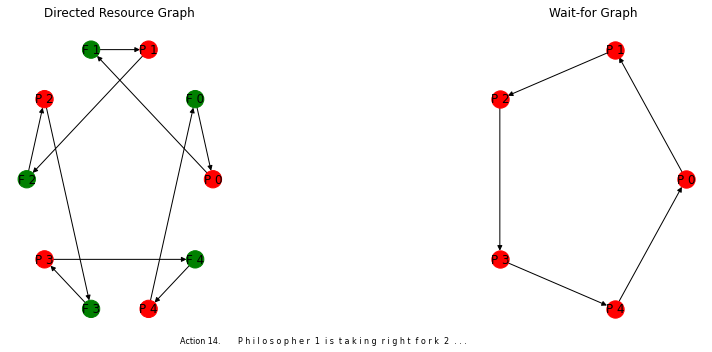

In [23]:
# making the animation gif
makeGraphsGif(deadlock_graphs,"deadlock_animation")

Here is the animation of the dining philosophers simulation when a deadlock
occus.

![deadlock_animation](Graph_Gifs/deadlock_animation.gif "segment")

We can see that the simulation does not get through many steps as a deadlock
occurs, which we an see when there is a cycle in the wait-for graph.


#### Asymmetric Graph :

Now for an animation of the dining philosophers simulation using solution 1
(Asymmetric Solution).

In [ ]:
# asym_graphs = diningPhilosophersGraphAfter(philosopher_amt=5,
#                                                    simulation_time=25,
#                                                    fork_pause_time=0.6,
#                                                    sim_type='asymetric')
#
# makeGraphsGif(asym_graphs,"asym_animation")

![asym_animation](Graph_Gifs/asym_animation.gif "segment")


From the graph above we can see that no deadlock occurs as we would expect


#### Symmetric Graph :

Now for an animation of the dining philosophers simulation usingthe complex
solution.

In [ ]:
# sol2_graphs = diningPhilosophersGraphAfter(philosopher_amt=5,
#                                                    simulation_time=25,
#                                                    fork_pause_time=0.6,
#                                                    sim_type='complex')
#
# makeGraphsGif(sol2_graphs,"sol2_animation")


![sol2_animation](Graph_Gifs/sol2_animation.gif "segment")

Again we can see that no deadlock occurs as we would expect.



#### Deadlock Detection (Extension 2) :

For the second extension I am using the ability to create wait for graphs
from the console output to be able to detected deadlocks while the dining
philosophers simulation is running and when a deadlock is detected for it to
rsolve the deadlocks by having one philosopher sleep for
`deadlock_sleep_time` while the other philosophers continue eatting.

The hard part of this eas figuring out how to capture the console output and
make the graphs in a reasonable amount of time while the simulation is running.

The general overview of how I accomplished this was using a thread called
`GraphMakerThread` which would capture the console output and use a
`multiprocessing.Queue` to pass the data to another processes called
`GraphMakerProcess` which would make the graphs as it got more lines
indicating what the simulation is doing then it would use a helper function
called `detectDeadlock` which would go through all the wait for graphs and
use the function `nx.simple_cycles()` to find cycles in the wait for graphs
which represent deadlocks. Then if a deadlock is found the
`GraphMakerProcess` will send a signal to the `DeadlockHandler` using another
 queue to tell it to sleep a philosopher for `deadlock_sleep_time` and then
 have it to continue eating to handle the deadlock. This entire deadlock
 handling simulation will be ran with the function
 `diningPhilosophersCatchDeadlock()`

#### Graph Making Thread and Process:

Below is the code for the `GraphMakerThread` and `GraphMakerProcess` which as
 explained before are used to capture the sim output and then make graphs to
 detect a deadlock.

Here is the code for the two classes below along with the helper function
`detectDeadlock()`.

In [ ]:
def detectDeadlock(wait_for_graphs: list) -> bool:
    '''
    Detects deadlock in the wait for graphs
    Args:
        wait_for_graphs (list): list of wait for graphs

    Returns:
        bool: True if deadlock detected, False otherwise

    '''
    # find all cycles in wait for graphs
    graph_cycles = []
    for wait_for_graph in wait_for_graphs:
        cycles = list(nx.simple_cycles(wait_for_graph))
        graph_cycles.append(cycles)

    # If any cycles exist, then there is a deadlock
    if any(cycles for cycles in graph_cycles):
        return True

    return False

class GraphMakerProcess(multiprocessing.Process):
    '''
    Process to create directed resource graph
    '''

    def __init__(self, directed_resource_graph, moves_queue, deadlock_queue):
        multiprocessing.Process.__init__(self, name="GraphMakerProcess")
        self.directed_resource_graph = directed_resource_graph
        self.is_running = True
        self.moves_queue = moves_queue
        self.deadlock_queue = deadlock_queue

    def run(self):

        current_moves = []
        while self.is_running:

            # get moves from the moves queue
            moves_list = self.moves_queue.get()

            if len(moves_list) > 1 and moves_list != current_moves:
                current_moves = moves_list
                di_graphs = createGraphs(current_moves, self.directed_resource_graph)


                wait_for_graphs = di_graphs[1]

                # Check for deadlock
                if detectDeadlock(wait_for_graphs):
                    self.deadlock_queue.put(True)

            pass


class GraphMakerThread(threading.Thread):
    '''
    This class is used to create a directed graph of resources and wait-for graph
    '''

    # Create running class attribute
    is_running = True

    def __init__(self, resource_graph: nx.DiGraph, moves_queue:multiprocessing.Queue):
        '''
        This method initializes a DirectedResourceGraphMaker object.

        Parameters:
            resource_graph: The graph to add the resources to.
            queue: The queue to add sys.out to.
        '''
        super().__init__(name=f"GraphMakerThread")
        self.resource_graph = resource_graph
        self.moves_queue = moves_queue
        return

    def run(self):
        '''
        This method runs the DirectedResourceGraphMaker object.
        '''

        captured_output = io.StringIO()  # Create StringIO object
        while self.is_running:
            with contextlib.redirect_stdout(captured_output):

                time.sleep(0.001)

            lines = captured_output.getvalue().split('\n')

            # Add the lines to the queue
            self.moves_queue.put(lines)

        return


#### Deadlock Handler Thread:

Here is the code for the `DeadlockHandlerThread` which is used to resolve a
deadlock in the dining philosophers simulation by having one of the philosophers
 sleep for `deadlock_sleep_time` and then continue eating to handle the
 deadlock. This will allow the other philosophers to continue eating while the
  one philosopher sleeps.

Here is the code below:



<br>


### Conclusion:

Overall, I found this project



#### Resources:
- [Dr. Al Madi](https://www.cs.colby.edu/nsalmadi/)
- [Using With Statements User Defined Objects](https://en.wikipedia.org/wiki/Peterson%27s_algorithm#Filter_algorithm:_Peterson's_algorithm_for_more_than_two_processes)
- [Animations in Notebook](https://hamnexik.medium.com/easily-display-animated-media-content-inside-your-jupyter-notebooks-5c200ef3ab03)